<h1>Challenge 2: Plankton Image Classification</h1>
<hr style="height:2px;border:none;color:#333;background-color:#333;"/>
<i>April 2019</i>

We decided to work directly with the images as they are provided. As we had worked with csv-files before we wanted to try a different approach to this problem. Reasoning for different decions are provided at the appropiate places through the notebook. 

## Data Exploration
<hr style="height:1px;border:none;color:#333;background-color:#333;" /> 

### Fetching Data

#### Importing libraries

In [12]:
%matplotlib inline
# For configuration and jupiter
import os
import sys
import re
import random
import matplotlib
import implicit
import warnings
# For data manipulation
import pandas as pd
import numpy as np
# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
# For prediction
from tqdm import tqdm

import zipfile
from extract_zip import extract_zip_to_memory # function for decompressing zip in memory
from PIL import Image, ImageOps # image handling
from io import BytesIO # image handling

basepath = '/mnt/datasets/plankton/flowcam/'

#### Fetching images

In [3]:
imgFiles = extract_zip_to_memory(basepath + "imgs.zip")

#### Fetching datasets and labels

In [13]:
# datasets
nativeDF = pd.read_csv(basepath + 'features_native.csv.gz')
skimagDF = pd.read_csv(basepath + 'features_skimage.csv.gz')
labelsDF = pd.read_csv(basepath + 'meta.csv')

labelsDF['objid'] = labelsDF['objid'].astype(np.int64, errors='ignore')
labelsDF['level1'] = labelsDF['level1'].fillna('No_level1_name')
labelsDF['level2'] = labelsDF['level2'].fillna('No_level2_name')

print(labelsDF.isnull().sum().any())

False


#### Exploring the datasets
We do not use the "features_skimage.csv.gz" dataset. "features_native.csv.gz" are used to look at the distribution of height and width of the images. Labels from "meta.csv" is used for training of the neural network. 

In [4]:
print("Total amount of pictures in the complete dataset: ", nativeDF.shape[0])
print("Maximum width in the dataset: ", nativeDF.width.max())
print("Maximum height in the dataset: ", nativeDF.height.max())

Total amount of pictures in the complete dataset:  243610
Maximum width in the dataset:  972
Maximum height in the dataset:  739


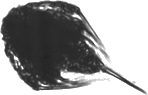

In [5]:
# display a picture
Image.open(imgFiles['imgs/32748610.jpg'])

In [6]:
print(labelsDF.loc[labelsDF["objid"] == 32748610.0].level2.values[0])

nauplii (Crustacea)


Above we can see a specimen of the "nauplii" taxonomy.

Text(90.125,0.5,'height of images')

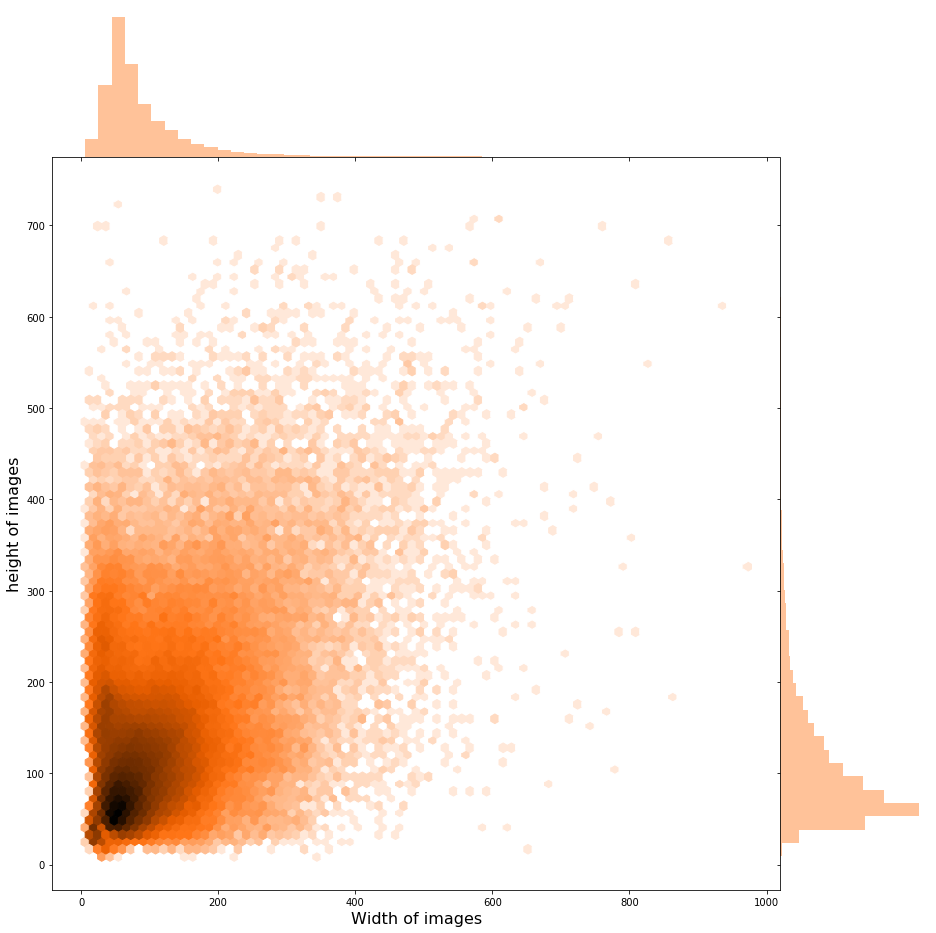

In [7]:
# Joint plot with histogram and binned scatter of the width and height of the images
cmap=plt.cm.gist_heat_r
hexmap = sns.jointplot(nativeDF.width, nativeDF.height, kind='hex', space=0, color=cmap(.3), height=13,  
                       joint_kws=dict(gridsize=80, bins="log"))
hexmap.ax_joint.set_xlabel('Width of images',  fontsize=16)
hexmap.ax_joint.set_ylabel('height of images', fontsize=16)



The above plot shows the distribution of the width and height of all the images in the dataset. We can see the majority of the images are less than 100x100 pixels (the bins used for plotting are normalized), but there are some images which are significantly bigger. The maximum width is 972 pixels and the maximum height is 739 pixels.

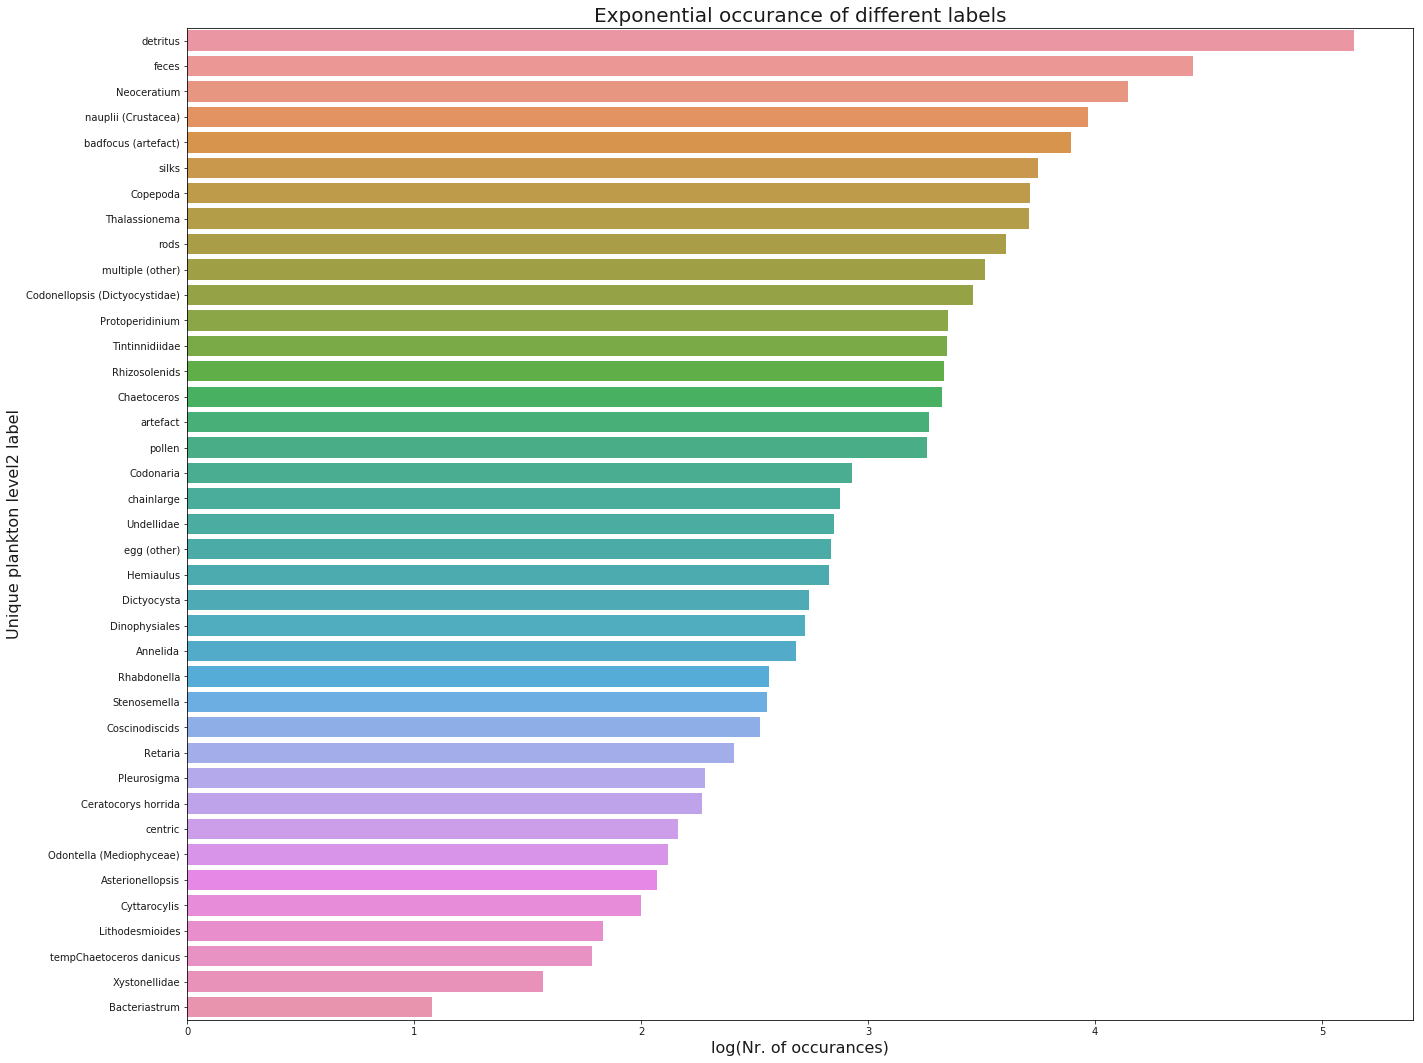

In [8]:
# Barplot
number_unique_names = labelsDF.groupby('level2', as_index=True)['id'].count()
number_unique_names.sort_values(inplace=True, ascending=False)

figure, ax = plt.subplots(figsize=(20,15))
ax = sns.barplot(y=number_unique_names.index, x=np.log10(number_unique_names.values))
sns.set(font_scale=1.2)

plt.ylabel('Unique plankton level2 label', fontsize= 16)
plt.xlabel('log(Nr. of occurances)', fontsize= 16)
plt.title('Exponential occurance of different labels', fontsize=20)
plt.tight_layout()

In [9]:
unique_names = labelsDF.groupby('level2', as_index=False)['id'].count()
unique_names.sort_values(inplace=True, ascending=False, by='id')

print(unique_names.iloc[0])
print(unique_names.iloc[-1])

level2    detritus
id          138439
Name: 30, dtype: object
level2    Bacteriastrum
id                   12
Name: 2, dtype: object


The plot above shows the distribution of the different labels that the different images are assigned to. The x axis is exponential as the most numerous labels would completly dominate the plot otherwise. There is a big disparity in the number of images within different label-classes. The least represented label (Bacteriastrum) has only 12 images and the most represented label (Detritus) have 138439 images. This will make classification difficult if left unaccounted for. 

## Data Pre-processing
<hr style="height:1px;border:none;color:#333;background-color:#333;" />    

The images in the dataset have varied height and width. As we will use a convoluted neural network (CNN) we need all images to be of the same input size. We solve this by creating a blank 972x972 (max size and square) image. We then scale up the orignal image to the new size. Next the original is put in the middle of the blank 972x972 which works like padding of the original. Finally we scale the image down to 100x100 as we chose this as the input shape for the CNN.

One of the cons of scaling the images before padding them with white pixels is that we loose the relative size parameter between different types of plankton. The alternatives would be to pad all the images up to the greatest size of 972x972, or deleting images over a certain size. The problem with scaling al the images up to 972x972 is that it would greatly increase the complexity of the NN, and most likely exceed the high memory we have available in this task. Deleting the images above a certain size is also a viable alternative, as they are few images that exceed 500 pixels in width or height. Below we show some statistics about how many "big images" there are. 

In [10]:
max_s = 500
w_500 = nativeDF[nativeDF['width'] >= max_s]['objid'].count()
h_500 = nativeDF[nativeDF['height'] >= max_s]['objid'].count()
b_500 = nativeDF[(nativeDF['width'] >= max_s) & (nativeDF['height'] >= max_s)]['objid'].count()
e_500 = w_500 + h_500 - b_500
print('Nr. of images with width greater than', max_s, 'pixels:', w_500)
print('Nr. of images with height greater than', max_s, 'pixels:', h_500)
print('Nr. of images with width and height greater than', max_s, 'pixels:', b_500)
print('Nr. of images with width or height greater than', max_s, 'pixels:', e_500)

unwanted_imgs = labelsDF[(nativeDF['width'] >= max_s) | (nativeDF['height'] >= max_s)]
print('labels-classes containing images ', unwanted_imgs['level2'].unique())

Nr. of images with width greater than 500 pixels: 294
Nr. of images with height greater than 500 pixels: 485
Nr. of images with width and height greater than 500 pixels: 66
Nr. of images with width or height greater than 500 pixels: 713
labels-classes containing images  ['silks' 'Neoceratium' 'Rhizosolenids' 'multiple (other)' 'detritus'
 'Copepoda' 'artefact' 'rods' 'feces' 'Dinophysiales' nan 'Annelida'
 'badfocus (artefact)' 'nauplii (Crustacea)']


As we can see, there are 713 images that are considered as "too big", by this metric. We will explore this more later. Below is the function we use to scale images to the correct size. 

In [11]:
def strip(key):
    return int(key[5:-4])

def reverse_strip(objid):
    return 'imgs/' + str(objid) + '.jpg'

def fetch_label(key, lvl='level2'):
    return list(labelsDF[labelsDF['objid']==strip(key)][lvl])[0]

# code inspired by https://jdhao.github.io/2017/11/06/resize-image-to-square-with-padding/
def image_processing(key):
    desired_size = 972 # max of width and height in dataset
    im_orginal = Image.open(imgFiles[key])
    old_size = im_orginal.size  # old_size[0] is in (width, height) format
    
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    im_scaled = im_orginal.resize(new_size) # scale up picture before padding to keep information
    
    delta_w = desired_size - new_size[0]
    delta_h = desired_size - new_size[1]
    padding = (delta_w//2, delta_h//2, delta_w-(delta_w//2), delta_h-(delta_h//2))
    im_padded = ImageOps.expand(im_scaled, padding, fill=255) # padding of scaled picture
    
    final_size = (100, 100) # input size for CNN
    im_final = im_padded.resize(final_size, resample=0) # resize to input size of CNN
    return np.array(im_final)

Earlier we discovered a disparity in the distribution of the different labels. This will make it more difficult for our Neural Network to predict the correct level 2 taxonomy for Plankton of the label-classes with fewer images. We attempt to resolve this by generating new images for the label-classes with fewer images. We do this by transposing, rotating and flipping the original image. This way we are able to generate 8 times more data in the underrepresented label-classes. We chose not to generate new data by randomly cropping or scaling the images, as we would loose control over what information about the planktons shape, and size was lost in the process.

Below, we reshape all the images in the original dictionary to size 100x100. We also attach the corresponding label to each image. After that we delete the initial dictionary imgFiles.

In [12]:
img_keys = list(imgFiles.keys())
processed_imgs = {strip(key) : [image_processing(key), fetch_label(key)] for key in img_keys} # Use tqdm here if it looks nice

In [13]:
del imgFiles

Below are the functions we use to generate new rotated, flipped and transposed duplicates of one image. Since the processed images are now numpy arrays, we can use basic numpy functions to perform said operations.

In [31]:
def strip(key):
    return int(key[5:-4])

def key_to_objid(list_of_keys):
    return [strip(key) for key in list_of_keys]

def reverse_strip(objid):
    return 'imgs/' + str(objid) + '.jpg'

def objid_to_key(list_of_objids):
    return [reverse_strip(objid) for objid in list_of_objids]

def fetch_label(key, lvl='level2'):
    return list(labelsDF[labelsDF['objid']==strip(key)][lvl])[0]

def generate_new_object_ids(object_id):
    stripped_key = str(object_id)
    key_lr = int('8' + stripped_key[1:])
    key_ud = int('1' + stripped_key[1:])
    key_90 = int('2' + stripped_key[1:])
    key_180 = int('4' + stripped_key[1:])
    key_270 = int('5' + stripped_key[1:])
    key_t1 = int('6' + stripped_key[1:])
    key_t2 = int('7' + stripped_key[1:])
    return {'lr' : key_lr, 'ud' : key_ud, '90' : key_90, '180' : key_180,
                '270' : key_270, 't1' : key_t1, 't2' : key_t2}

def generate_duplicates(object_id, image_files=processed_imgs):
    # Fetching and making numpy array of original object
    img_np_array = image_files[object_id][0]

    # Generating copies of data using numpy functions for flipping, rotating and transposing
    # Flip image up down
    img_flipped_ud = np.flip(img_np_array, 0)
    # Flip image left right
    img_flipped_lr = np.flip(img_np_array, 1)
    # Rotate image 90 degrees
    img_rot_90 = np.rot90(img_np_array, k=1)
    # Rotate image 180 degrees
    img_rot_180 = np.rot90(img_np_array, k=2)
    # Rotate image 270 degrees
    img_rot_270 = np.rot90(img_np_array, k=3) 
    # Transpose image (flip it around axis going from upper left corner to bottom right)
    img_tran_1 = np.transpose(img_np_array) 
    # Flip image around axis going from upper right corner to bottom left
    img_tran_2 = np.flip(np.transpose(np.flip(img_np_array, 1)), 1) 
    
    # Generating new keys
    key_dict = generate_new_object_ids(object_id)
    # Fetching label
    lbl = list(labelsDF[labelsDF['objid']==object_id]['level2'])[0]
    # Updating dictionary of images with new data
    image_files.update({key_dict['ud'] : [img_flipped_ud, lbl], key_dict['lr'] : [img_flipped_lr, lbl], 
                      key_dict['90'] : [img_rot_90, lbl], key_dict['180'] : [img_rot_180, lbl], 
                      key_dict['270'] : [img_rot_270, lbl], key_dict['t1'] : [img_tran_1, lbl], 
                      key_dict['t2'] : [img_tran_2, lbl]})
    
    return image_files

We have chosen to generate more data for images within label-classes that have less than a thousand images already. Here we collect the names of the labels-classes with less than a 1000 images, and the all the object IDs that pertain to certain label-classes. 

In [32]:
# Fetching the object ids that pertain to specific labels
unique_names = list(number_unique_names.index)
original_objid_dict = {}
# Fetching the level2 labels of the categories we want to duplicate
labels_to_multiply = []

critical_number_of_images = 1000

for name in unique_names:
    objid_labels = list(labelsDF.loc[labelsDF['level2'] == name, 'objid'])
    original_objid_dict.update({name : objid_labels})
    # Find labels that we want to generate more data within
    if len(objid_labels) < critical_number_of_images:
        labels_to_multiply.append(name)

Here we loop through the different labels we want to produce more data for, and produce "duplicates" for every object ID in that label-class.

In [33]:
# Actually generate more data
total_nr = 0
for label in labels_to_multiply:
    object_ids = original_objid_dict[label]
    print('For label:', label[:4], 'we generate', len(object_ids)*8, 'new images')
    total_nr += len(object_ids)*8
    for objid in object_ids:
        processed_imgs = generate_duplicates(objid)
print('Total nr of new images produced:', total_nr)
print('New number of images in total  :', len(list(processed_imgs.keys())))

For label: Codo we generate 6760 new images
For label: chai we generate 6008 new images
For label: Unde we generate 5680 new images
For label: egg  we generate 5480 new images
For label: Hemi we generate 5360 new images
For label: Dict we generate 4392 new images
For label: Dino we generate 4200 new images
For label: Anne we generate 3848 new images
For label: Rhab we generate 2936 new images
For label: Sten we generate 2856 new images
For label: Cosc we generate 2672 new images
For label: Reta we generate 2056 new images
For label: Pleu we generate 1528 new images
For label: Cera we generate 1488 new images
For label: cent we generate 1160 new images
For label: Odon we generate 1048 new images
For label: Aste we generate 936 new images
For label: Cytt we generate 800 new images
For label: Lith we generate 544 new images
For label: temp we generate 488 new images
For label: Xyst we generate 296 new images
For label: Bact we generate 96 new images
Total nr of new images produced: 60632


Now, let us have a look at what the new data distribution within label-classes looks like.

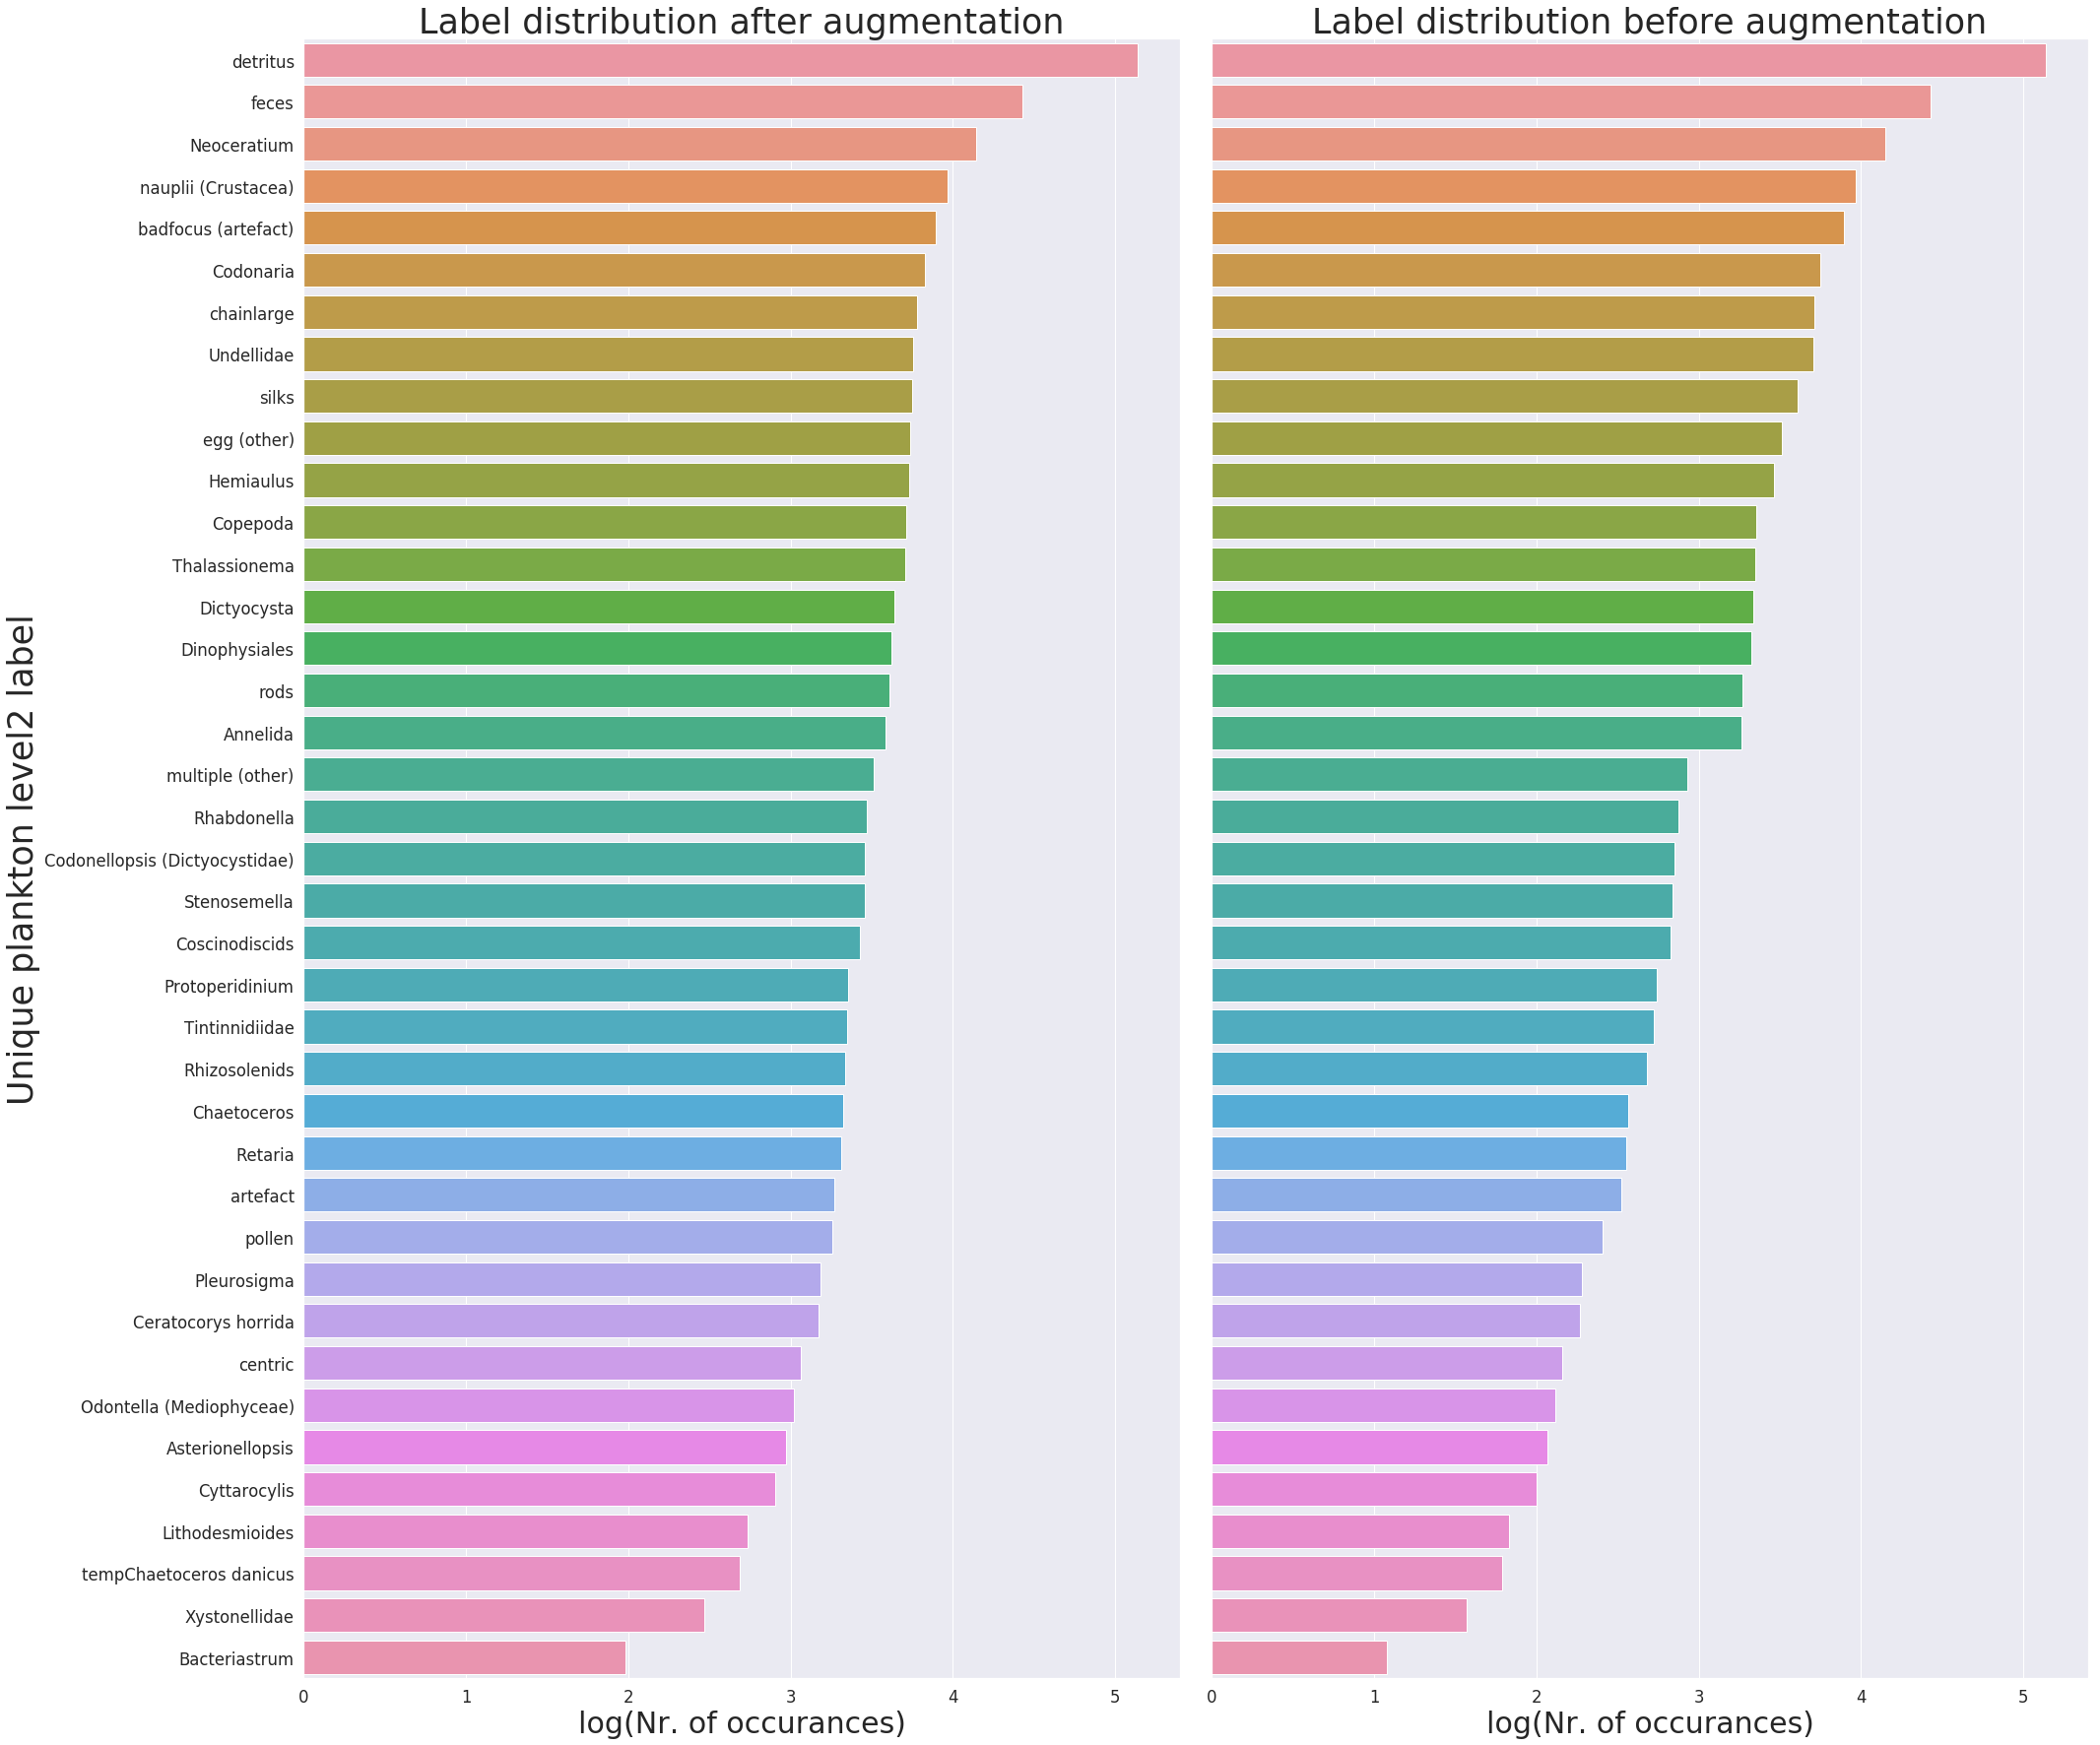

In [43]:
list_labels = []
for objid in list(processed_imgs.keys()):
    list_labels.append([objid, processed_imgs[objid][1]])

labels_objid_dict = {'objid' : [element[0] for element in list_labels],
                     'label' : [element[1] for element in list_labels]}
labelDF = pd.DataFrame.from_dict(labels_objid_dict)

number_unique_names2 = labelDF.groupby('label', as_index=True)['objid'].count()
number_unique_names2.sort_values(inplace=True, ascending=False)

fig = plt.figure(figsize=(30,25))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

sns.barplot(y=number_unique_names2.index, x=np.log10(number_unique_names2.values), ax=ax1)
sns.barplot(y=number_unique_names.index, x=np.log10(number_unique_names.values), ax=ax2)
ax2.set(yticks=[])
sns.set(font_scale=1.6)
S
ax1.set_ylabel('Unique plankton level2 label', fontsize=35)
ax1.set_xlabel('log(Nr. of occurances)', fontsize=30)
ax1.set_title('Label distribution after augmentation', fontsize=35)

ax2.set_ylabel('')
ax2.set_xlabel('log(Nr. of occurances)', fontsize=30)
ax2.set_title('Label distribution before augmentation', fontsize=35)
plt.tight_layout()

It made a slight difference in the data-distribution, but largest label-classes are still massively overrepresented. This is a big problem for our model. In contrast to regression models where we are trying to fit a curve, classifier models follow a Bernoulli distribution. This means that the each prediction that the model does is independent of the previous predictions. Such models are hard to train when using an unbalanced dataset, especially since we are giving accuracy within different label-classes equal weighting when calculating the F1 score.

Below we explore a couple of different NN structures. Each model is trained, and evaluated on small partition of the train, and test data (train size: 40000, test size: 4000)

In [44]:
def train_test_val_split(dict_objids_and_labels):
    train_objids = []
    test_objids = [] 
    val_objids = []
    for label in unique_names: # unique names are all labels in level 2 of labelsDF
        object_ids = dict_objids_and_labels[label]
        number_train = int(len(object_ids)*0.6)
        number_test = int(len(object_ids)*0.2)
        train_objids += object_ids[:number_train]
        test_objids += object_ids[number_train:(number_train + number_test)]
        val_objids += object_ids[(number_train + number_test):]
    return train_objids, test_objids, val_objids

# original_objid_dict
# augmented_objid_dict
train_objids, test_objids, val_objids = train_test_val_split(augmented_objid_dict)

train_objids = random.sample(train_objids, len(train_objids))
test_objids = random.sample(test_objids, len(test_objids))
val_objids = random.sample(val_objids, len(val_objids))

In [47]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# preprocessing found here: https://towardsdatascience.com/building-a-convolutional-neural-network-cnn-in-keras-329fbbadc5f5
# We want to label-encode the different categories so we can one-hot encode them.

def autoloader(list_of_object_ids):
    X = np.array([processed_imgs[object_id][0] for object_id in list_of_object_ids])
    y = np.array([processed_imgs[object_id][1] for object_id in list_of_object_ids])
    
    # label encode target column
    le = LabelEncoder()
    y = le.fit_transform(y)
    
    # one-hot encode target column
    y = to_categorical(y)
    
    # Reshape input data to account for images only being greyscale
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
    return X, y

# Fetch pictures and labels, corresponding to keys.
# train
X_train, y_train = autoloader(train_objids)
# val
X_val, y_val = autoloader(val_objids)
# test
X_test, y_test = autoloader(test_objids)


print('y_train shape:', y_train.shape)
print('y_test shape :', y_test.shape)
print('X_val shape:', X_val.shape)
print('X_val shape :', X_val.shape)
print('X_train shape:', X_train.shape)
print('X_test shape :', X_train.shape)


Using TensorFlow backend.


y_train shape: (40000, 40)
y_test shape : (4000, 40)
X_train shape: (40000, 100, 100, 1)
X_test shape : (40000, 100, 100, 1)


## Model Selection
<hr style="height:1px;border:none;color:#333;background-color:#333;" />    

Here we will evaluate different NN structures. Each inspired by models used in picture challenges such as MNIST. But, first we define a custom metric function to measure the f1 score of our model after training.

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

# Making metric for f1-score
# Found at https://www.kaggle.com/guglielmocamporese/macro-f1-score-keras
import tensorflow as tf
import keras.backend as K

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)

    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

Using TensorFlow backend.


In [50]:
# Input dimensions
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
# Network parameters 
batch_size = 50
classes = labelsDF.level2.unique()
num_classes = labelsDF.level2.nunique()
epochs = 1 # Further Fine Tuning can be done

In [ ]:
# Building the CNN structure 1: input -> conv(128) -> conv(32) -> flatten -> fc(40) -> softmax

# Create model---------------------------------------------------------------------------------------------
model0 = Sequential()

# Add layers
model0.add(Conv2D(128, kernel_size=3, activation='relu', input_shape=(100,100,1)))
model0.add(Conv2D(32, kernel_size=3, activation='relu'))
model0.add(Flatten())
model0.add(Dense(40, activation='softmax'))

# Compile model using accuracy to measure model performance -----------------------------------------------
model0.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summarize
model0.summary()
# Train the model -----------------------------------------------------------------------------------------
model0.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_test, y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 128)       1280      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 32)        36896     
_________________________________________________________________
flatten_1 (Flatten)          (None, 294912)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                11796520  
Total params: 11,834,696
Trainable params: 11,834,696
Non-trainable params: 0
_________________________________________________________________
Train on 40000 samples, validate on 4000 samples
Epoch 1/1
11800/40000 [=======>......................] - ETA: 18:09 - loss: 15.6367 - acc: 0.0298

In [ ]:
# Keras CNN model 1: input -> conv(32) -> pool(2,2) -> conv(64) -> pool(2,2) -> dropout(0.25) -> flatten -> fc(64) -> dropout(0.1) -> fc(40) -> softmax

# Create model------------------------------------------------------------------------------------------------
model1 = Sequential()
# add first  layer
model1.add(Conv2D(100, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model1.add(MaxPooling2D(pool_size=(2, 2)))

# add second layer
model1.add(Conv2D(80, kernel_size=(3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.5))

# add flatten layer
model1.add(Flatten())
model1.add(Dense(64, activation='relu'))
model1.add(Dropout(0.25))
# add last layer
model1.add(Dense(num_classes, activation='softmax'))

# Compile model using accuracy to measure model performance --------------------------------------------------
model1.compile(loss='categorical_crossentropy',  optimizer="adam", metrics=['accuracy', f1])
# Summary
model1.summary()

# Train the model --------------------------------------------------------------------------------------------
model1.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_test, y_test))

In [ ]:
# Keras CNN model 5: input -> conv(100) -> ReLu -> pool(2,2) -> conv(32) -> pool(2,2) -> conv(32) -> pool(2,2)-> flatten -> fc(64) -> dropout(0.5) -> fc(40) -> softmax


model2 = Sequential()

model2.add(Conv2D(100, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model2.add(Dense(64, activation='sigmoid'))
model2.add(Dropout(0.5))
model2.add(Dense(num_classes, activation='softmax'))

# COMPILE
model2.compile(loss='categorical_crossentropy',  optimizer='adam', metrics=['accuracy', f1])
# Summary
model2.summary()
# Train the model --------------------------------------------------------------------------------------------
model2.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_test, y_test))

- https://medium.com/@thongonary/how-to-compute-f1-score-for-each-epoch-in-keras-a1acd17715a2
- https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras

## Parameter Optimisation
<hr style="height:1px;border:none;color:#333;background-color:#333;" />    

## Model Evaluation
<hr style="height:1px;border:none;color:#333;background-color:#333;" />    

### Classification of Plankton based on features 


In [15]:
# nativeDF and labelsDF are imported at the start og the Notebook
native_nan_cols = ['perimareaexc', 'feretareaexc', 'cdexc', 'skeleton_area',
                   'nb1_area', 'symetrieh_area', 'symetriev_area', 'convarea_area',
                  'nb2_area', 'nb3_area', ]

for col_name in native_nan_cols:
    nativeDF[col_name] = nativeDF[col_name].fillna(0)

labelsDF['objid'] = labelsDF['objid'].astype(np.int64, errors='ignore')
labelsDF['level1'] = labelsDF['level1'].fillna('No_level1_name')
labelsDF['level2'] = labelsDF['level2'].fillna('No_level2_name')

print(nativeDF.isnull().sum().any())
print(labelsDF.isnull().sum().any())

False
False


In [16]:
y = labelsDF['level2'] 
X = nativeDF

from sklearn.model_selection import train_test_split

# Divide train data into train and validation sets

seed = 42
test_size = 0.20

X_train_csv, X_test_csv, y_train_csv, y_test_csv  = train_test_split(X, y, test_size = test_size, random_state = seed)

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score


model_csv = RandomForestClassifier(n_estimators=200, n_jobs=-1, criterion='entropy')
model_csv.fit(X_train_csv, y_train_csv)
model_predictions_csv = model_csv.predict(X_test_csv)
model_f1_csv = f1_score(y_test_csv, model_predictions_csv, ave)
print("Final F1 Score: ", K.get_value(model_f1_csv))

TypeError: Value passed to parameter 'x' has DataType string not in list of allowed values: bfloat16, float16, float32, float64, int32, int64, complex64, complex128